## Model evaluation

## Contents
* [Task description](#Task-description)
* [The experiment details](#The-experiment-details)
* [Results](#Results)


## Task description

For model performance assessment we want to obtain the distribution of the model accuracy over N independent runs of the training procedure.

## The experiment details

Dataset loading

In [1]:
import os
import sys
import glob
import dill
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import best_practice, B, V, C, Pipeline
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow.research import Research, Results

from src import show_histogram


mnist = MNIST()

Extracting /tmp/train-images-idx3-ubyte.gz
DownloadingDownloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Extracting http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz


Define model config

In [2]:
NUM_CLASSES = 10

model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                   labels=dict(classes=NUM_CLASSES, name='targets')),
    'body': dict(layout='cpna cpna cpna', filters=[64, 128, 256],
                 strides=2, pool_strides=1, kernel_size=3),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'initial_block/inputs': 'images',
    'loss': 'crossentropy',
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5}),
    'output': ['proba']}

Define training and test pipeline

In [3]:
batch_size = 64

train_template = (Pipeline()
                  .init_model('dynamic', TFModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')})
                  .run(batch_size, n_epochs=None, lazy=True))

test_template = (Pipeline()
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches='predictions', 
                                feed_dict={'images': B('images')},
                                save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics'), mode='u')
                 .run(batch_size, n_epochs=1, lazy=True))

Create a research object

In [4]:
train_ppl = (train_template << mnist.train)
test_ppl = (test_template << mnist.test)

research = (Research()
            .pipeline(train_ppl, name='train')
            .pipeline(test_ppl, variables='metrics', execute=-1,
                      name='test', run=True, import_from='train')
            .grid({}))

Run 20 independent training and test procedures 

In [5]:
research.run(n_reps=20, n_iters=937, name='model_estimation_research', progress_bar=True)

Research model_estimation_research is starting...


  0%|          | 0/18740 [00:00<?, ?it/s]

Distributor has 20 jobs with 937 iterations. Totally: 18740


100%|██████████| 18740/18740 [58:21<00:00,  5.35it/s]


Save accuracy metric to an array

In [6]:
df = Results(path='model_estimation_research').load()
values = df[df['name'] == 'test']['metrics'].apply(lambda x: x.evaluate('accuracy')).values

## Results

Accuracy histogram and the average value

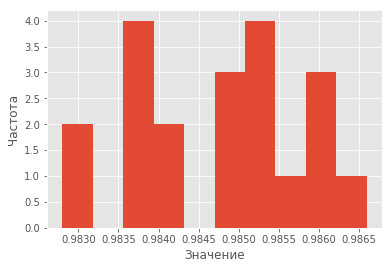

Среднее значение (медиана): 0.985


In [7]:
show_histogram(values)
print('Среднее значение (медиана): %.3f' % np.median(values))

The average value (median) is 0.985